In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage
from skimage import io
from scipy import special
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import math as m

In [2]:
def data_matrix(file_name,first_line=True,type="string"):
    """
    From a file_name which contains a table of numbers separated with tabulator,
    returns a matrix with those numbers, ignoring the first row.
    first_line: True (include the first line)
    type: "string" or "float"
    """
    infile=open(file_name,"r")
    if first_line==False:
        infile.readline() #skip the first line
    matrix=[]
    for line in infile:
        num_row=[]
        str_row=line.split()
        for n in str_row:
            if type=="float":
                n=float(n)
            num_row.append(n)
        matrix.append(num_row)
    return matrix
    infile.close()

def data_dictionary(file_name,location_list):
    """
    Creates a dictionary from file_name, using location_list with the syntax:
    location_list=[first term(list with: term name(str), first column(int), last column(int)), second term(...),...]
    location_list does not includes the keys, they should always be in the first column.
    Example of what it returns: {5.0: {'first': [7.99, 8.42, 7.96],'second': [8.11, 7.87, 7.93],'third': [7.9]},7.0: {'first': [15.89, 15.76, 15.7], 'second': [15.7, 16.1, 16.01], 'third': [15.76]},9.0: {'first': [21.73, 21.38, 21.0], 'second': [21.37, 21.65, 21.39], 'third': [21.84]},11.0: {'first': [27.08, 27.32, 27.14], 'second': [27.4, 27.52, 27.36], 'third': [27.21]},13.0: {'first': [32.24, 31.92, 31.85], 'second': [31.88, 32.4, 32.57], 'third': [31.95]},15.0: {'first': [37.06, 37.19, 36.65], 'second': [36.51, 36.0, 36.04], 'third': [36.46]},17.0: {'first': [41.32, 40.26, 41.6], 'second': [41.69, 40.88, 41.39], 'third': [41.64]}}
    """
    infile=open(file_name,"r")
    infile.readline() #skip the first line
    dic={}
    for line in infile:
        num_row={} #Dictionary for each line, which will go in dic with the main key.
        str_row=line.split() #Raw list with all the numbers in the working line.
        for term in location_list:
            term_list=[] #List for each different term that will go in num_row.
            for i in range(term[1],term[2]+1):
                n=float(str_row[i])
                term_list.append(n)
            num_row[term[0]]=term_list
        n=float(str_row[0]) #Main key
        dic[n]=num_row
    return dic
    
def write(file_name,something,name):
    """
    Writes something (string) on the last column with the name of the column.
    """
    D=data_matrix(file_name)
    D[0].append(name)
    for i in range(1,len(D)):
        D[i].append(something)
    outfile=open(file_name,"w")
    for i in D:
        j=i[0]
        outfile.write(j)
        for j in i[1:]:
            outfile.write("\t" + j)
        outfile.write('\n')
    outfile.close()

In [3]:
def plot_points(file_name,ci=1,cf=1):
    """
    Plots all of the data from the column ci to the column cf, against the first key column.
    """
    location_list=[["y",ci,cf]]
    d=data_dictionary(file_name,location_list)
    for i in range(0,cf-ci+1):
        yi=[]
        for k in d.keys():
            yi.append(d[k]["y"][i])
        plt.plot(d.keys(),yi,'b+')
        plt.hold('on')

def avrgc(file_name,ci=1,cf=1):
    """
    Computes the average of the data from column ci to column cf,
    returns a dictionary with the keys from the first column.
    """
    location_list=[["y",ci,cf]]
    d=data_dictionary(file_name,location_list)
    av={}
    for k in d.keys():
        a=0
        for i in range(0,cf-ci+1):
            a+=d[k]["y"][i]
        a=a/(cf-ci+1)
        av[k]=a
    return av
    
def avrg(file_name,c):
    """
    Computes the average of the data in column c,
    returns a list with the average and the standard deviation.
    """
    d=data_matrix(file_name,False,"float")
    a=0
    s=0
    for i in range(0,len(d)):
        a+=d[i][c]
    a=a/len(d)
    for i in range(0,len(d)):
        s+=(d[i][c]-a)**2
    s=m.sqrt(s/(len(d)-1))
    return [a,s]
    
def multi_avrg(file_names,ci_l,cf_l):
    """
    file_names: List with the file names.
    ci_l: List with the initial columns
    cf_l: List with the final columns.
    Computes the average of the data of the file_names, from their respective
    column ci to column cf, returns a dictionary with the keys from the first column. 
    """
    av={}
    N=0
    for i in range(0,len(file_names)):
        file_name=file_names[i]
        ci=ci_l[i]
        cf=cf_l[i]
        N+=cf-ci+1
        location_list=[["y",ci,cf]]
        d=data_dictionary(file_name,location_list)
        for k in d.keys():
            a=0
            for j in range(0,cf-ci+1):
                a+=d[k]["y"][j]
            if i==0:
                av[k]=a
            else:
                av[k]+=a
    for k in d.keys():
        av[k]=av[k]/N
    return av
       
def stdc(file_name,ci=1,cf=1):
    """
    Calculates the sample standard deviation of the data of each row from ci to cf.
    Returns a dictionary with the keys from the first column.
    """
    av=avrgc(file_name,ci,cf)
    location_list=[["y",ci,cf]]
    d=data_dictionary(file_name,location_list)
    dev={}
    for k in d.keys():
        devk=0
        for i in range(0,cf-ci+1):
            devk+=(d[k]["y"][i]-av[k])**2
        devk=devk/(cf-ci)
        devk=m.sqrt(devk)
        dev[k]=devk
    return dev
    
def multi_std(file_names,ci_l,cf_l):
    """
    file_names: List with the file names.
    ci_l: List with the initial columns
    cf_l: List with the final columns.
    Computes the sample standard deviation of the data of the file_names,
    from their respective column ci to column cf,
    returns a dictionary with the keys from the first column.
    """
    av=multi_avrg(file_names,ci_l,cf_l)
    dev={}
    N=0
    for i in range(0,len(file_names)):
        file_name=file_names[i]
        ci=ci_l[i]
        cf=cf_l[i]
        N+=cf-ci+1
        location_list=[["y",ci,cf]]
        d=data_dictionary(file_name,location_list)
        for k in d.keys():
            devk=0
            for j in range(0,cf-ci+1):
                devk+=(d[k]["y"][j]-av[k])**2
            if i==0:
                dev[k]=devk
            else:
                dev[k]+=devk
    for k in d.keys():
        dev[k]=dev[k]/(N-1)
        dev[k]=m.sqrt(dev[k])
    return dev

def dist_plot(file_name,ci=2,cf=2,xerr=1,yerr_type="Measurement",yerr=3):
    """
    Plots the average of the distribution from ci of cf with its
    asociated standard deviation if err_type="Standard deviation";
    or, if err_type="Measurement" with its mesurement error in the err column,
    plotting against the keys from column 0 with their measurement error.
    """
    avd=avrgc(file_name,ci,cf)
    avl=[]
    yerrl=[]
    xerrl=[]
    if yerr_type=="Standard deviation":
        yerrd=stdc(file_name,ci,cf)
        xerrd=data_dictionary(file_name,[["xerr",xerr,xerr]])
        yerrdkeys=sorted(yerrd)
        #yerrdkeys=yerrd.keys()
        #yerrdkeys.sort()
        for k in yerrdkeys:
            avl.append(avd[k])
            yerrl.append(yerrd[k])
            xerrl.append(xerrd[k]["xerr"][0])
    elif yerr_type=="Measurement":
        errd=data_dictionary(file_name,[["xerr",xerr,xerr],["yerr",yerr,yerr]])
        errdkeys=sorted(errd)
        #errdkeys=errd.keys()
        #errdkeys.sort()
        for k in errdkeys:
            avl.append(avd[k])
            yerrl.append(errd[k]["yerr"][0]/np.sqrt(cf-ci+1))
            xerrl.append(errd[k]["xerr"][0])
    
    x=sorted(avd)
    #x=avd.keys()
    #x.sort()
    plt.errorbar(x,avl,xerr=xerrl,yerr=yerrl,ls=':',label='Data')
    plt.legend() 
    plt.xlim(np.array(x).min()-3,np.array(x).max()+3) 
    plt.ylim(np.array(avl[:-1]).min()-3,np.array(avl[:-1]).max()+3) #Sin contar el último que es un nan
    plt.grid(True)
    plt.xlabel(r"$\theta_{i}$ [deg]")
    plt.ylabel(r"$\theta_{r}$ [deg]")
    plt.title(r'$\'Angulo\ reflejado$')
    
    #plt.show()
    
def plotc(file_name, c, av, dav, w, dw, R, dR, g, dg):
    """
    Plots the column c of file_name against the first column, with a model that is constant with respect to the
    parameter of the first column, so
    av:average of the column
    """
    d=data_matrix(file_name,False,"float")
    xdata=[]
    xerrl=[]
    ydata=[]
    yerrl=[]
    avl=[]
    mavl=[]
    pavl=[]
    modell=[]
    mmodell=[]
    pmodell=[]
    for i in d:
        xdata.append(i[0])
        xerrl.append(10)
        ydata.append(i[c])
        yerrl.append(0.5)
        avl.append(av)
        mavl.append(av-dav)
        pavl.append(av+dav)
        modell.append(model(w,R,g))
        mmodell.append(model(w,R,g)-err_model(w,dw,R,dR,g,dg))
        pmodell.append(model(w,R,g)+err_model(w,dw,R,dR,g,dg))
        
    plt.errorbar(xdata,ydata,xerr=xerrl,yerr=yerrl,ls=':',label="Datos")
    
    plt.plot(xdata, avl, 'r-', label='Promedio')
    plt.fill_between(xdata,mavl,pavl,alpha=0.5,edgecolor='#CC4F1B', facecolor='#FF9848')
    
    plt.plot(xdata, modell, 'g-', label='Modelo')
    plt.fill_between(xdata, mmodell, pmodell,alpha=0.5, edgecolor='#3F7F4C', facecolor='#7EFF99',linewidth=0)
    
    plt.grid(True)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('h [cm]')
    plt.legend()
    plt.title('Altura R(10.5cm) w(14.3125rad/s)')
    plt.show()

In [27]:
Io=16.5
#Io=0
zo=0
Wo=195
def model(I, zr):
    return Wo*np.sqrt(1+np.power(((I+Io)-zo)/zr,2))

def err_model(I, dI, zr, dzr):
    z=I+Io
    return Wo*dzr*np.power(z-zo,2)/(np.power(zr,2)*(np.power(zr,2)+np.power(z-zo,2)))

In [33]:
#Io=16.5
Io=0
def model(I, zo, Wo, zr):
    return Wo*np.sqrt(1+np.power(((I+Io)-zo)/zr,2))

def err_model(I, dI, zo, dzo, Wo, dWo, zr, dzr):
    z=I+Io
    return np.sqrt((1+np.power((z-zo)/zr,2))*np.power(dWo,2)+np.power(Wo*(z-zo)*dzo/np.power(zr,2),2)*1/(np.power(zr,2)+np.power(z-zo,2))+np.power(Wo*dzr*np.power(z-zo,2)/np.power(zr,2),2)*1/(np.power(zr,2)+np.power(z-zo,2)))

In [58]:
a=np.arange(0,10,1)*2
print(a)

[ 0  2  4  6  8 10 12 14 16 18]


<IPython.core.display.Javascript object>


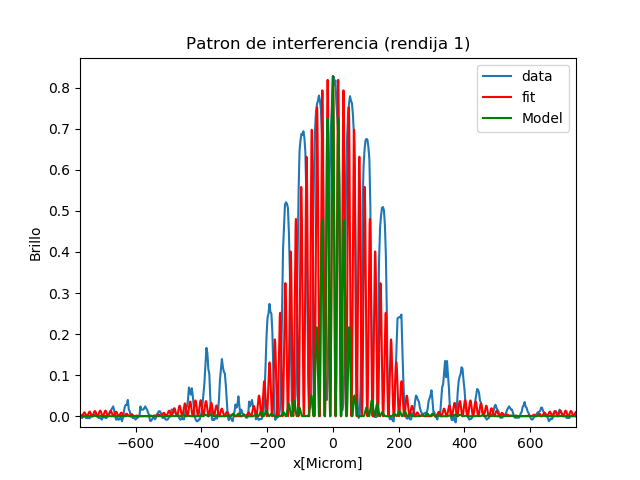

[  59.25122261 1047.9785233 ]
[[ 1.80149547e+00 -1.90601301e-05]
 [-1.90601301e-05  1.80110310e+00]]


In [61]:
#EN MICROMETROS
a=0.20E3
g=1.00E3
L=0.685
z=70000
#z=70000
dx=0.5
fit("a20s100r.png",[a,g],[0.005E3,0.005E3], z)

In [59]:
def fit(Image, Po, Po_err, z):
    """
    Fits the function func to the average of the data from ci to cf, 
    with the associated error for each row if err_type is "Measurement";
    if err_type is "Standard deviation", then it calculates the standard
    deviation of the data and uses it as the error.
    Requires a pre-defined func.
    Po: List of the initial guess of the parameters.
    Po_err: List of the respective measurement error of the parameters.
    """
    f = io.imread(Image)
    f=skimage.color.rgb2gray(f)
    cuch=0.015
    f=f-(f.min()+cuch) #Bajar el valor de f a la minima intensidad    
    
    c=np.argmax(f[0]) #Lugar del máximo
    
    #Aproximando el maximo como promedio pesado de los primers n máximos
    t=0
    n=100
    center=0 
    for i in np.argsort(f[0])[-n:]:
        t+=1 #Función peso
        center+=t*i
    center=center/(n*(n+1)/2)
    
    A=f[0][c]
    a=Po[0]
    
    xdata=np.arange(-center,len(f[0])-center,1.0)*2.95 #2.23 o 2.68 es el ancho del pixel
    sigma=np.array([0.05]*len(f[0]))
    
    xdataE=[] #Making a list of points in the area of interest of the data for plotting fit and model.
    n=1
    m=2 #Parameters for the lenght of the area of interest, n for adding length to the left, m to the right.
    d=500.0 #Parameter for density of points (bigger d, more points) MUST BE FLOAT
    E=(xdata[-1]-xdata[0])/len(xdata)
    left=np.arange(xdata[0]-n*E,xdata[0],1.0/d)
    right=np.arange(xdata[-1],xdata[-1]+m*E,1.0/d)
    xdataE=left.tolist()
    for i in range(0,len(xdata)-1):
        r=np.arange(xdata[i],xdata[i+1],1.0/d)
        xdataE=xdataE+r.tolist()
    xdataE=xdataE+right.tolist()
    
    xdataE=np.array(xdataE)
    
    #def env(x, A):
    #    fx=x/(L*z)
    #    return A*np.power(np.cos(a*g*fx),2)
        #return A*np.power(np.sinc(np.pi*a*x/(L*np.sqrt(np.power(x,2)+np.power(z,2)))),2)
    #popt, pcov = curve_fit(env, xdata, f[0], A, sigma, maxfev=10000)
    #A=popt[0]
    #print A
    
    #plt.plot(xdataE, env(xdataE, A), 'b-', label='model_env')
        
    plt.plot(xdata, f[0], label="data")
    
    def model(x, a, g):
        #sinc(x)=sin(pi*x)/(pi*x) ASI LA TOMA PYTHON
        #fx=x/(L*z)
        #return A*np.power(np.sinc(a*fx/2),2)*np.power(np.cos(a*g*fx),2)
        return A*np.power(np.sinc(a*x/(L*np.sqrt(np.power(x,2)+np.power(z,2)))),2)*np.power(np.cos(np.pi*g*x/(L*np.sqrt(np.power(x,2)+np.power(z,2)))),2)
    
    def err_model(x, dx, a, da, g, dg):
        return 0.001

    popt, pcov = curve_fit(model, xdata, f[0], Po, sigma, maxfev=5000)
    
    ##AJUSTE DE DOS PARAMETROS
    plt.plot(xdataE, model(xdataE, *popt), 'r-', label='fit')
    #plt.fill_between(xdataE,model(xdataE, *popt)-err_model(xdataE,0,popt[0],pcov[0][0],popt[1],pcov[1][1]),model(xdataE, *popt)+err_model(xdataE,0,popt[0],pcov[0][0],popt[1],pcov[1][1]),alpha=0.5,edgecolor='#CC4F1B', facecolor='#FF9848')
    
    ##Comparison to a model with theoretical parameters.
    plt.plot(xdataE, model(xdataE, *Po), 'g-', label='Model')
    #plt.fill_between(xdataE, model(xdataE,*Po)-err_model(xdataE,0,Po[0],Po_err[0],Po[1],Po_err[1]), model(xdataE, *Po)+err_model(xdataE,0,Po[0],Po_err[0],Po[1],Po_err[1]),alpha=0.5, edgecolor='#3F7F4C', facecolor='#7EFF99',linewidth=0)
    
    print(popt)
    print(pcov)
    
    plt.xscale("linear")
    plt.yscale("linear")
    plt.xlim(xdataE.min()-E,xdataE.max()+E)
    plt.ylim(np.array(f[0]).min()-0.1,np.array(f[0]).max()+0.1)
    plt.locator_params(numticks=10)
    plt.xlabel("x[Microm]")
    plt.ylabel("Brillo")
    plt.legend()
    plt.title('Patron de interferencia (rendija 1)')
    plt.show()

In [6]:
def P_file(file_name):
    """
    Escribe en file_name todos los parámetros esperados.
    """
    Rl=["R[cm]",14.1,14.2,14.5,11.2,11.3,11.3,11.2,11.4,10.5,10.1,10.5]
    
    dRl=["dR[cm]",0.7,0.7,0.7,0.7,0.7,0.7,0.8,0.8,0.7,0.7,0.7]
    
    wl=["w_crit[r/s]"]
    dwl=["dw_crit[r/s]"]
    
    for i in range(1,len(Rl)):
        wl.append(m.sqrt(978/Rl[i]))
        dwl.append(m.sqrt(9**2/(4*978*Rl[i])+978*dRl[i]**2/(4*Rl[i]**3)))
    
    D=[]
    D.append([Rl[0],dRl[0],wl[0],dwl[0]])
    for k in range(1,len(Rl)):
        row=[]
        row=[str(Rl[k]),str(dRl[k]),str(round(wl[k],3)),str(round(dwl[k],3))]
        D.append(row)
    
    outfile=open(file_name,"w")
    for i in D:
        j=i[0]
        outfile.write(j)
        for j in i[1:]:
            outfile.write("\t" + j)
        outfile.write('\n')
    outfile.close()


xo=21
yo=0
x1=57
y1=20.6

def line_fit_dispersion(file_name, n):
    """
    Returns the weighted sum of squares of a line fit with respect to the data (from the first one till the nth one) 
    in file_name(string).
    S=sum((y(xi)-yi)/dyi)**2
    where y(xi) is the expected value at x=xi and yi is the measured value +-dyi
    """
    D=data_matrix(file_name,False,"float")
    
    xo=D[0][0]
    yo=D[0][1]
    xn=D[n-1][0]
    yn=D[n-1][1]
    M=(yn-yo)/(xn-xo)
    def y(x):
        return M*x+(yo-M*xo)
    S=0
    t=0
    for r in D:
        t+=1
        S+=((y(r[0])-r[1])/r[3])**2
        if t==n:
            break
    return S
    
def sum_rel_err(file_name, n):
    """
    Returns the sum of relative errors der=((yi+1-yi)/dyi)**2 of subsecuent data of a dataset until the nth data.
    The dataset in the second column (element 1 of a list) and error of the dataset on the 4th column (element 3 of a list)
    """
    D=data_matrix(file_name,False,"float")
    der=0
    for t in range(0,n-1): 
        der+=((D[t+1][1]-D[t][1])/D[t][3])**2
    return der
    
    
def best_data_lft(file_name):
    """
    Returns n>=2 such that a data set frpm i=1 to n is optimal, ie
    a=S/(der*(n-1)**2) is minimal.
    """
    D=data_matrix(file_name,False,"float")
    a=0
    amin=0
    nmin=3
    for n in range(3,len(D)+1):
        S=line_fit_dispersion(file_name, n)
        der=sum_rel_err(file_name, n) 
        a=S/((n-1)**2*der)
        if n==3:
            amin=a
        elif a<amin:
            amin=a
            nmin=n
    return [nmin,amin]
    
def plotsoliton(k,h):
    L=np.sqrt(4*h**3/(3*k))
    x=np.arange(-20*k,20*k,0.1)
    u=np.cosh(x/L)
    plt.plot(x,k*np.power(u,-2))
    plt.xlim(-15*k,15*k)
    plt.ylim(-15*k,15*k)